## Unsupervised Learning

### I. Load Datasets

In this section I import all the libraries needed for this question. Also as we are going to use labeled and unlabeled dataset to train autoencoders, I concatenate the labeled and unlabeled training data.

In [ ]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch import tensor
from torch.optim import Adam
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# Load training and test datasets
labeled_df = pd.read_csv('Task2C_labeled.csv')
unlabeled_df = pd.read_csv('Task2C_unlabeled.csv')
test_df = pd.read_csv('Task2C_test.csv')

# Inspect the data
labeled_df.shape, test_df.shape, unlabeled_df.shape

((50, 785), (500, 785), (1500, 784))

In [93]:
# label is in first column and the remaining columns are the image itself
# split into X and Y
X_labeled = labeled_df.iloc[:,1:]
Y_labeled = labeled_df.iloc[:,0]
X_test = test_df.iloc[:,1:]
Y_test = test_df.iloc[:,0]

# since we want to use both labeled and unlabeled data, concatenate both into training data
X = np.concatenate([X_labeled, unlabeled_df], axis= 0)

X.shape

(1550, 784)

### II. Train An Autoencoder with One Hidden Layer

An **autoencoder** is a type of neural network used for **unsupervised learning** tasks such as dimensionality reduction, denoising, and feature learning. It consists of two main components:

- **Encoder**: Maps the input data to a lower-dimensional hidden layer.
- **Decoder**: Attempts to reconstruct the original input from hidden layer.

Autoencoders are trained by minimizing the **reconstruction error** (usually Mean Squared Error), encouraging the model to capture meaningful structure in the data.

The compressed (latent) features can then be used for downstream tasks like **visualization**, **clustering**, or **classification**.

In this part, I implemented an autoencoder using PyTorch. The network uses:

- Hidden layers with `Tanh` activation
- A bottleneck layer of dimension 2 for visualization
- A linear output layer for reconstruction

The model is trained using the **Adam optimizer** for 20 epochs. There is only one hidden layer but we are going to analyze the effect of hidden units in the hidden layers to the performance of the model. Thus, I use different numbers of hidden units to train the autoencoder.

In [94]:
def normalize(x, m=None, s=None): 
    if m is None or s is None:
        #print('Normalizing data: No mean and/or sd given. Assuming it is training data')
        m,s = x.mean(), x.std()
        
    return (x-m)/s

def get_dataloader(X_train,Y_train=None, autoencoder=False,bs=128, standardize=True, return_dataset=False):
    """
    Retrieves a data loader to use for training. In case autoencoder=True, Y_train automatically is set to X_train
    The function returns the dataloader only if return_dataset is False otherwise it returns a tuple (dataloader,train_dataset)
    where train_dataset is the Dataset object after preprocessing.
    """
    try:
        X_train= np.array(X_train).astype(np.float32)
        if standardize: X_train = normalize(X_train)
        if not autoencoder: Y_train = np.array(Y_train)
    except Exception as e:
        raise Exception('Make sure your input and labels are array-likes. Your input failed with exception: %s'%e)
    # transform into tensors
    if autoencoder:
        Y_train = X_train
    
    X_train, Y_train = map(tensor, (X_train, Y_train))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
            
    train_ds = TensorDataset(X_train,Y_train)
    train_dl = DataLoader(train_ds, batch_size=16)
    
    if return_dataset: return train_dl,train_ds
    
    return train_dl

def train_autoencoder(X_train,hidden,activation='Tanh',epochs=10, trace=True, device="cpu", **kwargs):
    """
    Trains an Autoencoder and returns the trained model
    
    Params:
    X_train: Input data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    epochs: Number of epochs to train autoencoder
    
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    
    **kwargs: passed to Adam optimizer, lookup adam optimizer for more details
    """
    train_dl = get_dataloader(X_train,autoencoder=True)
    
    device = device
    
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = n_inps
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses = []
    # define optimizer with learning rate
    optim = Adam(model.parameters(), **kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.MSELoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')

    return model, epoch_losses


In [ ]:
epochs = 50
lr = 0.001
activation = 'Tanh'
hidden_units = range(20,221,40)
AE_models = {hidden:[] for hidden in hidden_units}

for hidden in hidden_units:
    AE_model, _ = train_autoencoder(    
        X_train = X, # training data
        hidden = [hidden], # number of layers and their units
        epochs = epochs, # maximum number of epoches  
        activation = activation, # activation function
        lr = lr   #learning rate
        )
    AE_models[hidden] = AE_model

### III. Record and Plot Reconstruction Error

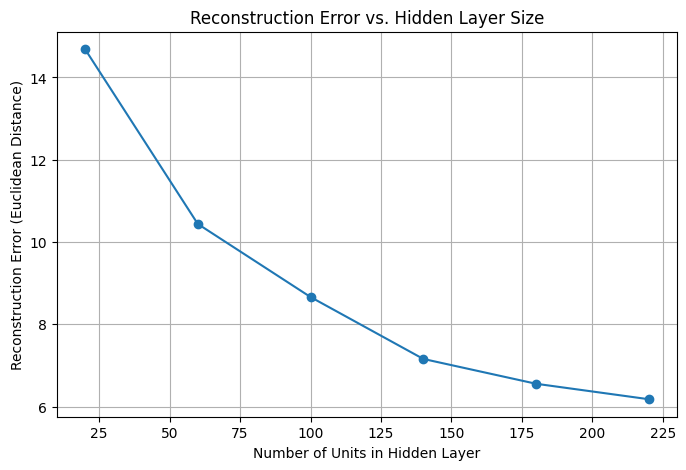

In [53]:
# to store reconstruction errors
reconstruction_errors = []

# convert data into tensor format
X_tensor = torch.tensor(normalize(X), dtype=torch.float32)

# move data to the same device as model
X_tensor = X_tensor.to("cpu")

# compute reconstruction error for each model
for hidden in hidden_units:
    model = AE_models[hidden]
    with torch.no_grad():
        output = model(X_tensor)
        error = torch.norm(X_tensor - output, p =2, dim=1).mean().item()
        reconstruction_errors.append(error)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(hidden_units, reconstruction_errors, marker='o')
plt.xlabel("Number of Units in Hidden Layer")
plt.ylabel("Reconstruction Error (Euclidean Distance)")
plt.title("Reconstruction Error vs. Hidden Layer Size")
plt.grid(True)
plt.show()

### IV. Implement 3-Layer Neural Network for Classification

In this part, I implement `train_classifier`. Unlike the `train_autoencoder` which does not use the label data, the classifier output dimension is not the same as the input, since it will use the label as target. Therefore, the classifier will only use labeled data for its training. Thus making it a supervised learning, unlike the autoencoder which is an unsupervised learning.

I train the classifier with 50 epochs with different numbers of hidden units similar to the autoencoder training. Then I compute and store the test errors for later comparison with the augmented self-taught networks.

In [ ]:
def train_classifier(X_train,Y_train,hidden,activation='Tanh',epochs=10, trace=True,device="cpu", **kwargs):
    """
    Trains a feedforward classifier and returns the trained model
    
    Params:
    X_train: Training data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    Y_train: Training labels. Can be a Series, 1D numpy array, 1-D list or a tensor with 1 dimension
    
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    epochs: Number of epochs to train autoencoder
    
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    """
    train_dl = get_dataloader(X_train,Y_train,autoencoder=False)

    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = [len(Y_train.unique())]   # is not a good idea if you are expecting very large datasets
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    #print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses =[]
    # define optimizer with learning rate
    optim = Adam(model.parameters(),**kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.CrossEntropyLoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            xb
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        #if trace and not epoch%printing_step:
            #print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')

    return model, epoch_losses

def get_deepfeatures(trained_model, X_input,layer_number):
    '''
    Gets deep features of a given `layer_number` upon passing `X_input` through a `trained_model`   
    '''
    X_input = get_dataloader(X_input,autoencoder=True,return_dataset=True)[1].tensors[0]
    result = []
    def save_result(m,i,o):
        result.append(o.data)
    hook = trained_model[layer_number].register_forward_hook(save_result)

    with torch.no_grad():
        trained_model(X_input)

    hook.remove()
    
    return (result[0].cpu().numpy())


In [91]:
epochs = 50
lr = 0.001
activation = 'Tanh'
hidden_units = range(20,221,40)
test_error = []
Xtest_tensor = torch.tensor(normalize(X_test.values), dtype=torch.float32).to("cpu")
Ytest_tensor = torch.tensor(Y_test.values).long().to("cpu")

for hidden in hidden_units:
    model, _  = train_classifier(    
        X_train = normalize(X_labeled.values), # training data
        Y_train = Y_labeled, # training label
        hidden = [hidden], # number of layers and their units
        epochs = epochs, # maximum number of epoches  
        activation = activation, # activation function
        lr = lr   #learning rate
        )
    with torch.no_grad():
        preds = model(Xtest_tensor)
        predicted_labels = torch.argmax(preds, dim=1)
        err = (predicted_labels != Ytest_tensor).float().mean().item()
        test_error.append(err)

### V. Implement Augmented Self-Taught Networks

In this section I train augmented self-taught networks by using the output from the hidden layer of the autoencoder from Step II as extra feature for the input. Aside from using the `train_classifier` with the same arguments as the standard 3-layer NN in the previous step, I use the `get_deepfeatures` function to extract the extra features from the autoencoder hidden layer. Then I concatenate the extra feature to the original input (the input of the classifier in Step IV). I compute and store the error for this training as well. 

Lastly, I plot both the errors from Step IV and Step V to compare their performance.

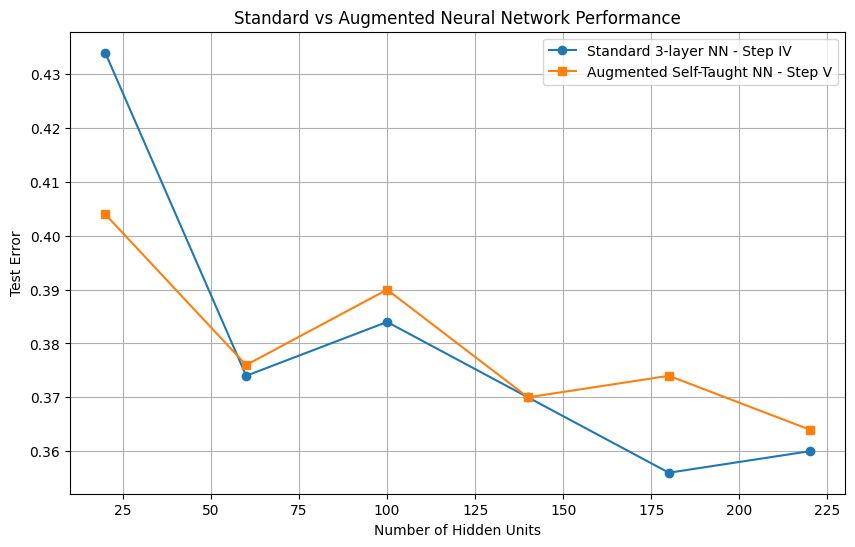

In [ ]:
epochs = 50
lr = 0.001
activation = 'Tanh'
hidden_units = range(20,221,40)
NN_test_error = []

# to store the extra features
extra_train = {hidden:[] for hidden in hidden_units}
extra_test = {hidden:[] for hidden in hidden_units}

for hidden in hidden_units:
    # extract features from autoencoder models in Step II then concatenate with original features
    extra_train[hidden] = get_deepfeatures(AE_models[hidden], X_labeled, layer_number=1)
    X_labeled_NN = np.concatenate([normalize(X_labeled.values), extra_train[hidden]], axis=1)
    
    extra_test[hidden] = get_deepfeatures(AE_models[hidden], X_test, layer_number=1)
    X_test_NN = np.concatenate([normalize(X_test.values), extra_test[hidden]], axis=1)

    # train 3-layer Neural Network using all features
    NN, _ = train_classifier(    
        X_train = X_labeled_NN, # training data
        Y_train = Y_labeled, # training label
        hidden = [hidden], # number of layers and their units
        epochs = epochs, # maximum number of epoches  
        activation = activation, # activation function
        lr = lr   #learning rate
        )
    
    # calculate and record test error
    Xtest_tensor = torch.tensor(X_test_NN, dtype=torch.float32).to("cpu")
    Ytest_tensor = torch.tensor(Y_test.values).long().to("cpu")

    with torch.no_grad():
        preds = NN(Xtest_tensor)
        predicted_labels = torch.argmax(preds, dim=1)
        err = (predicted_labels != Ytest_tensor).float().mean().item()
        NN_test_error.append(err)

plt.figure(figsize=(10, 6))
plt.plot(hidden_units, test_error, marker='o', label='Standard 3-layer NN - Step IV')
plt.plot(hidden_units, NN_test_error, marker='s', label='Augmented Self-Taught NN - Step V')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Test Error')
plt.title('Standard vs Augmented Neural Network Performance')
plt.legend()
plt.grid(True)
plt.show(block=True)

### Analysis

Both models show a decrease in test error as the number of hidden units increases. The trend is **non-monotonic**, meaning test error doesn't consistently decrease, which is expected due to model variance and potential overfitting. To compare more in detail, below is the analysis based on number of hidden units:
   - At **20 hidden units**, the **augmented self-taught network** performs noticeably better than the standard model (test error drops from ~0.434 to ~0.404).
   - From **60 to 140 hidden units**, both models perform similarly, with minor differences in favor of either model.
   - At **180 and 220 hidden units**, the **standard model slightly outperforms** the augmented version.

Around **140 hidden units**, both models converge to a similar test error (≈ 0.37), suggesting that additional features from the autoencoder are less impactful when the base model already has enough capacity.

Below I list more comparison explaining why the two models are different
1. **Advantages of Unlabeled Data for Low-Capacity Models**:
- At low capacity (e.g., 20 hidden units), the standard neural network struggles to learn good internal representations from labeled data alone.
- The augmented network leverages features from an **autoencoder trained on both labeled and unlabeled data**, improving its feature representation and leading to lower test error.

2. **Diminishing Returns as Model Capacity Grows**:
- As the number of hidden units increases, the standard network becomes more capable of learning complex patterns directly from the original features.
- The **relative benefit of the extra autoencoder features decreases** at higher capacities.
- In fact, at high capacity (180–220 units), the augmented network may slightly underperform due to:
  - **Overfitting** introduced by noisy or redundant features.
  - **Misalignment** between unsupervised features and supervised classification objectives.

3. **Nature of Autoencoder Features**:
- The autoencoder is **unsupervised**, so the features it learns are not optimized for the classification task.
- These features help more when the model is **weak** (low-capacity), but add less value (or even noise) as the model's own representational power increases.

#### Conclusion:

The augmented self-taught network demonstrates clear benefits in low-capacity settings, highlighting the value of semi-supervised learning and unsupervised pretraining when labeled data is limited or when model complexity is constrained.

As model capacity increases, the benefit of extra features diminishes, and the standard network catches up or slightly outperforms
